# W2 Discussion

## Linear Regression in PyTorch:

Recall that for Linear Regression:

- Training Data: $S = \{x_i,y_i\}_{i=1}^N$
- Model Class: $f(x|w,b) = w^Tx - b$
- Loss Function: $L(a,b) = (a-b)^2$

In [1]:
import torch, numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.0.0+cu117


# Load the data

We will load the data with pandas

In [3]:
# Load the dataset
train_df = pd.read_csv('../archive/train.csv')
test_df = pd.read_csv('../archive/test_public.csv')

# Encode the Data

Convert all categorical data to numerical values

In [109]:
encoder = LabelEncoder()
train_df['CALL_TYPE'] = encoder.fit_transform(train_df['CALL_TYPE'])
train_df['DAY_TYPE'] = encoder.fit_transform(train_df['DAY_TYPE'])

# Split the data into features and target
features = train_df.drop(['TRIP_ID', 'MISSING_DATA', 'POLYLINE'], axis=1).head(1000)
target = train_df['POLYLINE'].head(1000).str.count(',') * 15

for i in range(1000):
    features.iloc[i, 3] -= 20000000
    features.iloc[i, 4] -= 1372636853

print(features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

     CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND  TAXI_ID  TIMESTAMP  DAY_TYPE
0            2          NaN           NaN      589          5         0
1            1          NaN           7.0      596        450         0
2            2          NaN           NaN      320         98         0
3            2          NaN           NaN      520          1         0
4            2          NaN           NaN      337        238         0
..         ...          ...           ...      ...        ...       ...
995          2          NaN           NaN      113      31411         0
996          2          NaN           NaN      256      31450         0
997          1          NaN          15.0      678      31318         0
998          2          NaN           NaN      320      27391         0
999          1          NaN          33.0       30      29722         0

[1000 rows x 6 columns]


In [110]:
# Check for NaN values and replace with zeros
X_train[X_train != X_train] = 0
X_val[X_val != X_val] = 0

X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_train = torch.unsqueeze(y_train, 1)
y_val = torch.unsqueeze(y_val, 1)

# X_train_batches = torch.split(X_train, 1000)
# X_val_batches = torch.split(X_val, 1000)
# y_train_batches = torch.split(y_train, 1000)
# y_val_batches = torch.split(y_val, 1000)

print(X_train)

tensor([[2.0000e+00, 0.0000e+00, 0.0000e+00, 2.3500e+02, 3.7020e+03, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 1.8600e+02, 2.7826e+04, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 3.8000e+01, 6.1800e+02, 2.8351e+04, 0.0000e+00],
        ...,
        [1.0000e+00, 0.0000e+00, 4.2000e+01, 1.2600e+02, 3.0446e+04, 0.0000e+00],
        [0.0000e+00, 4.5930e+03, 0.0000e+00, 5.8000e+01, 2.4167e+04, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 6.7200e+02, 1.7630e+03, 0.0000e+00]])


# PyTorch Linear Regression

Let us construct a very simple neural network with 1 linear layer (2 parameters, 1 weight and 1 bias) and train it using:
- Training Data: $S = {x_i,y_i}_{i=1}^N$
- Model Class: $f(x|w,b) = w^Tx - b$
- Loss Function: $L(a,b) = (a-b)^2$

Note: There is an analytical solution to the Least-Squares Linear Regression problem using the pseudo-inverse. We are using gradient descent to solve it just as an example.

In [164]:
# Define Model
class LinearRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LinearRegression, self).__init__()
    self.layer = torch.nn.Sequential(
      torch.nn.Linear(input_dim, output_dim),
    )

  def forward(self, x):
    out = self.layer(x)
    return out
  
model = LinearRegression(6, 1)
# Define Loss Function / Objective Function
loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [165]:
train_err = []
test_err = []
parameters = []
for i in range(10000):
  model.train()
  # print(X_train)
  # for j, x_batch in enumerate(X_train_batches):
  x = torch.nn.functional.normalize(X_train, p=1.0, dim=0)
  y_pred = model(X_train) # Compute model outputs
  y_pred[y_pred != y_pred] = 0
  # print(y_pred)
  loss = loss_fn(y_pred, y_train) # Compute MSE
  opt.zero_grad() # Must reset the gradients every step. Otherwise, gradients from previous iterations would cause interference!!!
  loss.backward() # Compute gradients of all parameters (our model) with respect to our computed loss value (a singular value)
  nn.utils.clip_grad_norm_(model.parameters(), 0.5)
  opt.step() # One gradient step
  
  # print(loss.item())
  train_err.append(loss.item())
  
  model.eval()
  with torch.no_grad():
    test_err.append(loss_fn(model(X_val[0]), y_val[0]).item())

In [166]:
import math

final_pred = model(X_train)
print(final_pred, math.sqrt(loss_fn(final_pred, y_train).item()))

tensor([[ 455.8023],
        [1338.4150],
        [1934.4408],
        [1401.8230],
        [1575.9500],
        [1198.0781],
        [ 796.3787],
        [1707.2847],
        [1270.7152],
        [1967.6283],
        [ 881.3167],
        [1320.1990],
        [1131.6533],
        [1496.8434],
        [1508.5288],
        [ 998.8937],
        [ 751.0181],
        [1116.3307],
        [1864.3829],
        [1346.6705],
        [ 733.5250],
        [1513.9237],
        [2023.1243],
        [ 181.9957],
        [1763.7557],
        [ 426.6724],
        [1536.0410],
        [1162.3864],
        [2186.5503],
        [1911.6631],
        [1590.5962],
        [2143.3894],
        [1240.5958],
        [1841.0071],
        [ 562.0844],
        [ 130.2224],
        [1124.3490],
        [1985.9386],
        [ 796.7343],
        [ 479.7559],
        [ 687.3536],
        [1314.3861],
        [1015.5616],
        [1236.7198],
        [1149.6873],
        [ 792.1657],
        [1422.3104],
        [ 231

In [151]:
print(f"Final Model: {model.layer[0].weight} {model.layer[0].bias}")

Final Model: Parameter containing:
tensor([[-0.0926,  0.0055, -1.0980,  1.3302,  0.0368, -0.1870]],
       requires_grad=True) Parameter containing:
tensor([0.0326], requires_grad=True)


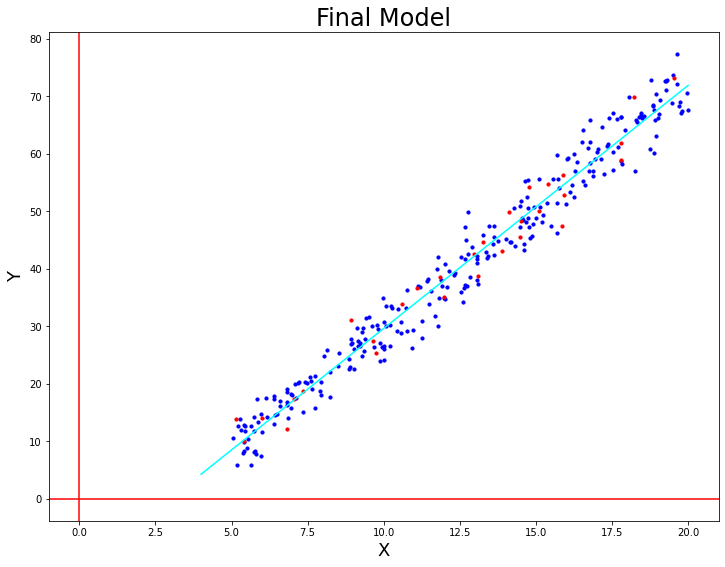

In [ ]:
visualize_data([X_tr, X_te], [y_tr, y_te], "Final Model")

with torch.no_grad():
  line_x = torch.linspace(4, 20, 100)
  line_y = model(line_x.reshape((-1, 1))).flatten()
  plt.plot(line_x, line_y, color="cyan")

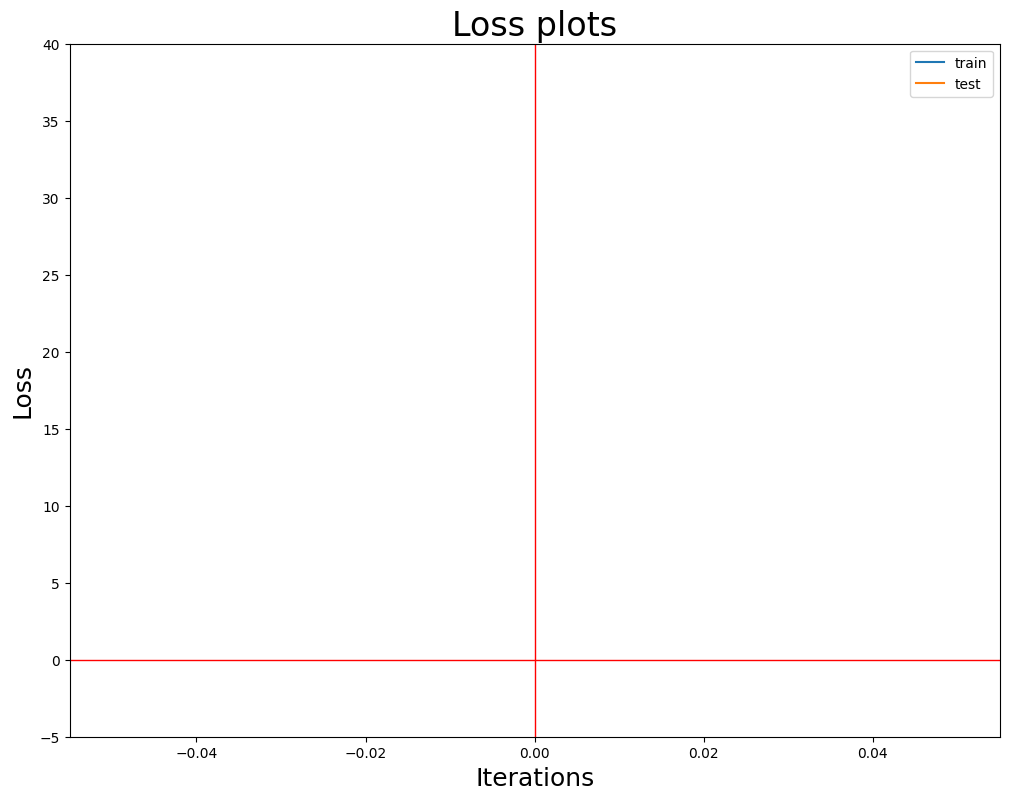

In [61]:
def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(-5, 40)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")